In [2]:
import unicodedata
from matplotlib import pyplot as plt
import snip
from numpy import array
import numpy as np

In [4]:
# Import and process raw data
raw_data = snip.loadmat('./XRMBsJW11m.mat')

all_data = raw_data['data']
all_label = raw_data['Phones']

training_lable = all_label['training'].transpose()
testing_lable = all_label['testing'].transpose()
tuning_lable = all_label['tuning'].transpose()

print('len(trainning),tuning and tesing = %i,%i,%i'%(len(training_lable),len(testing_lable),len(tuning_lable)))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(training_lable)

training_code = le.transform(training_lable)
tuning_code = le.transform(tuning_lable)
testing_code = le.transform(testing_lable)

len(trainning),tuning and tesing = 8527,2933,2573


# (a) Use baseline 39-features to do KNN

In [6]:
# First get dev and test data with baseline feature only
training_data = all_data['view1']['training'][117:156,:].transpose()
tuning_data = all_data['view1']['tuning'][117:156,:].transpose()
testing_data = all_data['view1']['testing'][117:156,:].transpose()

from sklearn.neighbors import KNeighborsClassifier
list_ks = [4,8,12,16]

knn_objs = []
for k in list_ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(training_data,training_code)
    knn_objs.append(knn)

for i in range(len(list_ks)):
    score = knn_objs[i].score(tuning_data,tuning_code)
    print('(info) acurracy for k=%i on tuning set = %.3f'%(list_ks[i],score))

(info) acurracy for k=4 on tuning set = 0.820
(info) acurracy for k=8 on tuning set = 0.814
(info) acurracy for k=12 on tuning set = 0.812
(info) acurracy for k=16 on tuning set = 0.808


So best k to use based on tuning set is k=4. Accuracy for testing set is as follows

In [19]:
test_score = knn_objs[0].score(testing_data,testing_code)

print('(Results) acurracy for k=4 on testing set = %.3f'%test_score)

# (b) PLS+MFCC39

/Users/ray/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


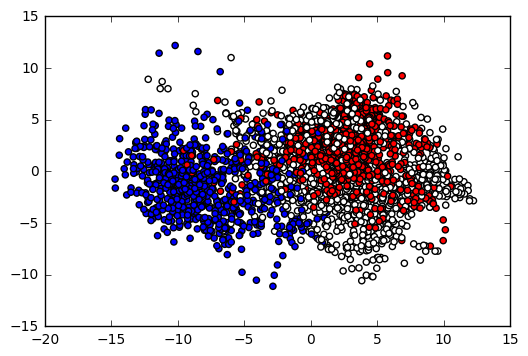

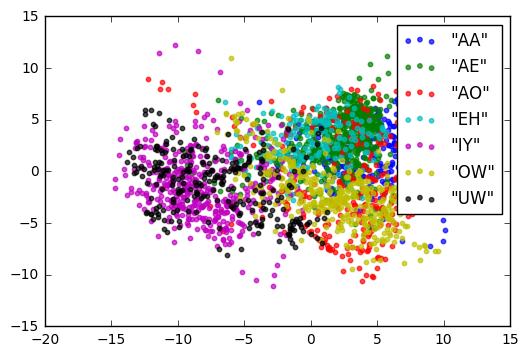

(info) Evaluationg with d=10.
(info) acurracy for k=4 on tuning set = 0.8181
(info) Evaluationg with d=30.
(info) acurracy for k=4 on tuning set = 0.8220
(info) Evaluationg with d=50.
(info) acurracy for k=4 on tuning set = 0.8263
(info) Evaluationg with d=70.
(info) acurracy for k=4 on tuning set = 0.8274
(info) Evaluationg with d=90.
(info) acurracy for k=4 on tuning set = 0.8286
(info) Evaluationg with d=110.
(info) acurracy for k=4 on tuning set = 0.8278
(result) Best accuracy for k=4 kNN is 0.8286 with d=90.


In [66]:
# First get dev and test data 
datasets = ['training','tuning','testing']
view1,view2 = [],[]
for name in datasets:
    view1.append(all_data['view1'][name])
    view2.append(all_data['view2'][name])

# mean center everything
view1_mean = view1[0].mean(axis=1)
view2_mean = view2[0].mean(axis=1)
center_view1 = lambda m: m.T-view1_mean
center_view2 = lambda m: m.T-view2_mean

for i in range(len(view1)):
    view1[i] = center_view1(view1[i]).T
    view2[i] = center_view2(view2[i]).T

size_training = view1[0].shape[1]

Cxy = view1[0]@view2[0].T/(size_training-1)

# Find eigenvalues and eigenvectors of Cxy
from scipy import linalg
U, s, Vh = linalg.svd(Cxy)
# U=(u1,u2,u3,..,u_dx), with Cxy@u_i = lambda_i u_i

def group_codes(old_code_array):
    """
    group codes into smaller groups
    """
    # 4/6->10,0/1->20,else->30
    conversion = {4:'b',6:'b',0:'r',1:'r'}
    return np.array([conversion.get(code,'w') for code in old_code_array])

# Get X projection to d singular vectors of Cxy
new_feature = U[:,:2].transpose()@view1[1]

new_color_tuning = group_codes(tuning_code)
plt.scatter(new_feature[0,:],new_feature[1,:],c = new_color_tuning)
plt.legend(loc='best')
plt.show()

all_colors = ['b','g','r','c','m','y','k','w']
color_map_full = {}
for i,val in enumerate(le.classes_):
    color_map_full[val] = all_colors[i]
    
def plotter(data_2D,labels):
    for i,iclass in enumerate(le.classes_):
        selected = np.where(tuning_lable==iclass)[0]
        plt.scatter(data_2D[0,selected],data_2D[1,selected],color=color_map_full[iclass],label=iclass,s=10, alpha=0.7)
    plt.legend(loc='best')
    plt.show()

plotter(new_feature,tuning_lable)

# define a kNN test code
def kNN_test(training_set,tuning_set,test_label = tuning_code):
    """
    input: training and tuning set , R n*dx
    output: knn score based on tuning set
    """
    best_score = 0
    for k in list_ks:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(training_set,training_code)
        score = knn.score(tuning_set,test_label)
        print('(info) acurracy for k=%i on tuning set = %.4f'%(k,score))     
        best_score = score
    return best_score

def eval_RL(U,hyper_list):
    """
    Use kNN to evaluate learned representations
    input: Learned subspace basis, list of hyper parameters, which is first d eigenvectors
    output: print out results of kNN evaluation
    """
    best_d = 0
    best_score = 0
    for d in hyper_list:
        print('(info) Evaluationg with d=%i.'%d)
        new_training_set = U[:,:d].T@view1[0]
        new_training_set = np.concatenate((view1[0][117:156,:].T,new_training_set.T),axis=1)
        new_tuning_set = U[:,:d].T@view1[1]
        new_tuning_set = np.concatenate((view1[1][117:156,:].T,new_tuning_set.T),axis=1)
        score = kNN_test(new_training_set,new_tuning_set)
        if score>best_score:
            best_score = score
            best_d = d
    return best_score,best_d

PLS_dims = [10,30,50,70,90,110]
list_ks = [4]
# PLS_dims = [10,110]
# list_ks = [4,16].
best_score, best_d = eval_RL(U,PLS_dims)
print('(result) Best accuracy for k=4 kNN is %.4f with d=%i.'%(best_score,best_d))

Therefore, for PLS, Best accuracy for k=4 kNN is 0.8286 with d=90.

In [68]:
def get_kNN_test_score(U,d):
    print('(info) Evaluationg with d=%i.'%d)
    new_training_set = U[:,:d].T@view1[0]
    new_training_set = np.concatenate((view1[0][117:156,:].T,new_training_set.T),axis=1)
    new_testing_set = U[:,:d].T@view1[2]
    new_testing_set = np.concatenate((view1[2][117:156,:].T,new_testing_set.T),axis=1)
    score = kNN_test(new_training_set,new_testing_set,test_label=testing_code)
    print('(result) Testing accuracy for k=4 kNN is %.4f with d=%i.'%(score,d)) 
    return score
get_kNN_test_score(U,90)

(info) Evaluationg with d=90.
(info) acurracy for k=4 on tuning set = 0.9489
(result) Testing accuracy for k=4 kNN is 0.9489 with d=90.


0.94885782475281277

# (c) CCA

In [73]:
# First get Cxx, Cyy 
Cxx = (view1[0]@view1[0].T)/size_training
Cyy = (view2[0]@view2[0].T)/size_training

view1_size = len(Cxx)
view2_size = len(Cyy)

reg_list = [1e-8,1e-6,1e-4,1e-2,1e-1,10]
CCA_d = [10,30,50,70,90,110]
# reg_list = [1e-8,10]
# CCA_d = [10,110]
best_score,best_d,best_regX,best_regY = 0,0,0,0
for regX in reg_list:
    for regY in reg_list:
        print('(info) CCA with regX=%.2e,regY=%.2e'%(regX,regY))
        # find egien vectors of Cxx-1CxyCyy-1Cxy.T
        new_m = linalg.inv(Cxx+regX*np.identity(view1_size))@Cxy@linalg.inv(Cyy+regY*np.identity(view2_size))@Cxy.T
        s,U_CCA = linalg.eig(new_m)
        print('first 5 eigenvals are',s[0:5])
        # Get first d dim eigenvector projections of tuning data for knn evaluation
        score,d = eval_RL(U_CCA,CCA_d)
        if score>best_score:
            best_score = score
            best_d = d
            best_regX = regX
            best_regY = regY
print('\n(Result) Best accuracy = %.4f for d=%i, regX =%.2e, regY=%.2e.'%(best_score,best_d,best_regX,best_regY))

(info) CCA with regX=1.00e-08,regY=1.00e-08
first 5 eigenvals are [ 0.82415597+0.j  0.78011268+0.j  0.76743808+0.j  0.63322241+0.j
  0.61769819+0.j]
(info) Evaluationg with d=10.


/Users/ray/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/ray/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:373: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


(info) acurracy for k=4 on tuning set = 0.8232
(info) Evaluationg with d=30.
(info) acurracy for k=4 on tuning set = 0.8232
(info) Evaluationg with d=50.
(info) acurracy for k=4 on tuning set = 0.8228
(info) Evaluationg with d=70.
(info) acurracy for k=4 on tuning set = 0.8228
(info) Evaluationg with d=90.
(info) acurracy for k=4 on tuning set = 0.8232
(info) Evaluationg with d=110.
(info) acurracy for k=4 on tuning set = 0.8224
(info) CCA with regX=1.00e-08,regY=1.00e-06
first 5 eigenvals are [ 0.82036643+0.j  0.77425693+0.j  0.75956327+0.j  0.62466615+0.j
  0.58954910+0.j]
(info) Evaluationg with d=10.
(info) acurracy for k=4 on tuning set = 0.8228
(info) Evaluationg with d=30.
(info) acurracy for k=4 on tuning set = 0.8236
(info) Evaluationg with d=50.
(info) acurracy for k=4 on tuning set = 0.8236
(info) Evaluationg with d=70.
(info) acurracy for k=4 on tuning set = 0.8239
(info) Evaluationg with d=90.
(info) acurracy for k=4 on tuning set = 0.8236
(info) Evaluationg with d=110.
(i

(Result) Using k=4 kNN classifier,Best accuracy = 0.8442 for d=110, regX =1.00e-01, regY=1.00e-08.

# (d) Plotting top two CCA

first 5 eigenvals are [ 0.80919648+0.j  0.75739635+0.j  0.75573683+0.j  0.60510299+0.j
  0.58763531+0.j]


/Users/ray/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


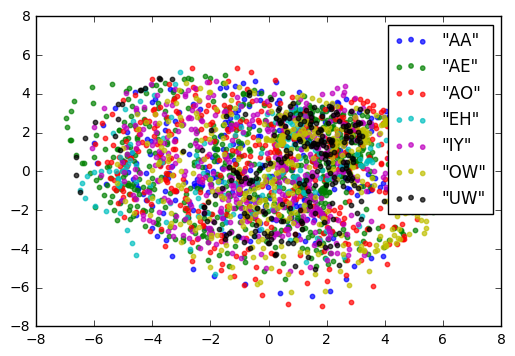

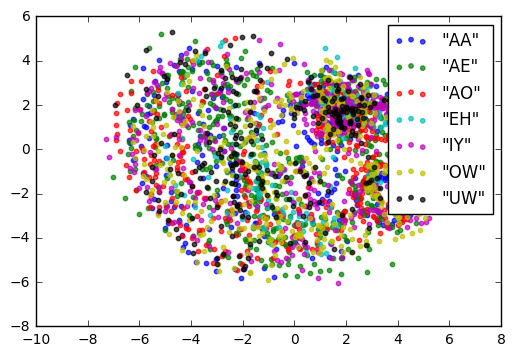

(info) Evaluationg with d=110.


/Users/ray/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/ray/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:373: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


(info) acurracy for k=4 on tuning set = 0.9482
(result) Testing accuracy for k=4 kNN is 0.9482 with d=110.


0.94817592908285031

In [74]:
new_m = linalg.inv(Cxx+1e-1*np.identity(view1_size))@Cxy@linalg.inv(Cyy+1e-8*np.identity(view2_size))@Cxy.T
s,U_CCA = linalg.eig(new_m)
print('first 5 eigenvals are',s[0:5])

new_training_set = U_CCA[:,:2].T@view1[0]
#     print(new_training_set.shape)
new_testing_set = U_CCA[:,:2].T@view1[2]

plotter(data_2D=new_training_set,labels=training_lable)
plotter(data_2D=new_testing_set,labels=testing_lable)

# Get accuracy on testing set by adding CCA features
get_kNN_test_score(U=U_CCA,d=110)

In above plot, red=['UW','IY'] which is closed, and blue=['AE','AA] (open) and white is other phones